In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from tqdm import tqdm
from helpers import *
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import sys
import os
import time


device = "cuda" if torch.cuda.is_available() else "cpu"

<font size="6">Load train and validation data</font>

In [9]:
dataset = get_dataset(dataset="fmow", download=False)

ood_train_data = dataset.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

ood_val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

BATCH_SIZE = 64
ood_train_loader = get_train_loader("standard", ood_train_data, batch_size=BATCH_SIZE)
ood_val_loader   = get_train_loader("standard", ood_val_data, batch_size=BATCH_SIZE)
id_val_loader    = get_train_loader("standard", id_val_data, batch_size=BATCH_SIZE)


TypeError: 'DataLoader' object is not subscriptable

<font size="6">Define the resnet50 backbone model</font>

In [4]:
class ResNet50_Backbone(nn.Module):
	def __init__(self):
		super(ResNet50_Backbone, self).__init__()

		self.resnet50 = torchvision.models.resnet50(pretrained=True)
		self.resnet50 = nn.Sequential(*(list(self.resnet50.children())[:-1])) # remove fc layer from resnet50
		for parameter in self.resnet50.parameters():
			parameter.requires_grad = False

		self.model = nn.Sequential(
			nn.Conv1d(1, 1, kernel_size=3, padding=1),
			nn.Dropout(0.4),
			nn.ReLU(),
			nn.MaxPool1d(8),
			nn.BatchNorm1d(1),
			nn.Conv1d(1, 1, kernel_size=3, padding=1),
			nn.Dropout(0.3),
			nn.ReLU(),
			nn.MaxPool1d(4),
			nn.BatchNorm1d(1),
			nn.Flatten(),
			nn.Linear(64, 62),
			nn.Dropout(0.5),
			nn.Sigmoid()
		)

	def forward(self, x):
		resnet_features = self.resnet50(x)
		resnet_features = torch.squeeze(resnet_features)
		resnet_features = torch.unsqueeze(resnet_features, dim=1)
		output = self.model(resnet_features)
		return output

<font size="6">Train and accumulate evaluation per epoch</font>

In [8]:
NUM_EPOCHS = 1
LEARNING_RATE = 0.01
MODEL_PATH = os.path.join("models", "resnet50_backbone")

model = ResNet50_Backbone()
model.to(device)

model_name = f"resnet50_backbone_conv_overhead_sigmoid_{NUM_EPOCHS}_Adam_{LEARNING_RATE}_CrossEntropy.pt"
save_name = os.path.join(MODEL_PATH, model_name)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_evolution = []
val_evolution = []
id_val_evolution = []
best_loss = sys.float_info.max

for epoch in range(NUM_EPOCHS):
	start_epoch_time = time.time()
	print(f"EPOCH {epoch + 1}:")
	# train
	y_true, y_pred, metadata, loss = train_step(model, ood_train_loader, loss_fn, optimizer, device)
	train_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))

	# validation
	y_true, y_pred, metadata, loss = val_step(model, ood_val_loader, loss_fn, device)
	val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))

	# save by best ood loss
	if loss < best_loss:
		best_loss = loss
		torch.save(model, save_name)

	# in distribution validation
	y_true, y_pred, metadata, loss = val_step(model, id_val_loader, loss_fn, device)
	id_val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))

	print(f"Took {time.time() - start_epoch_time}")


EPOCH 1:


  1%|          | 1/180 [00:00<02:42,  1.10it/s]


Took 3.1016783714294434
EPOCH 2:


  1%|          | 1/180 [00:01<03:04,  1.03s/it]


Took 3.093268871307373
EPOCH 3:


  1%|          | 1/180 [00:00<02:58,  1.00it/s]

Took 3.0039868354797363


<font size="6">F1 score on validation datasets</font>

In [6]:
y_true, y_pred, metadata, loss = val_step(model, id_val_loader, loss_fn, device)
f1 = f1_score(y_true, y_pred, average="weighted")
print("In distribution F1 score: ", f1)

y_true, y_pred, metadata, loss = val_step(model, ood_val_loader, loss_fn, device)
f1 = f1_score(y_true, y_pred, average="weighted")
print("Out of distribution F1 score: ", f1)

  1%|          | 1/180 [00:00<02:49,  1.05it/s]


In distribution F1 score:  0.011383928571428573


  0%|          | 1/312 [00:00<04:55,  1.05it/s]

Out of distribution F1 score:  0.010974702380952382


<font size="6">Plot loss and accuracy per region</font>

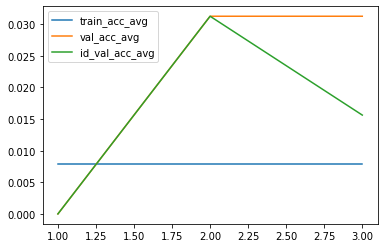

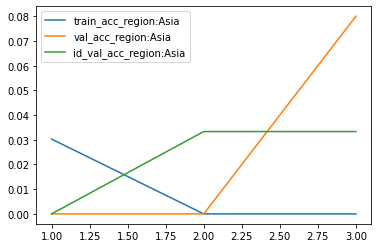

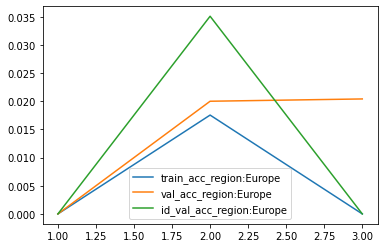

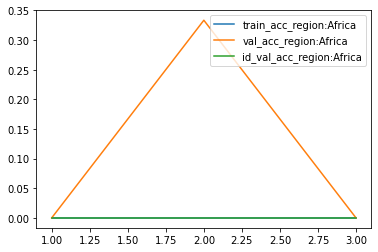

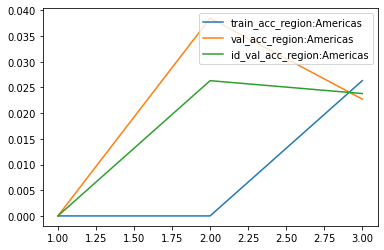

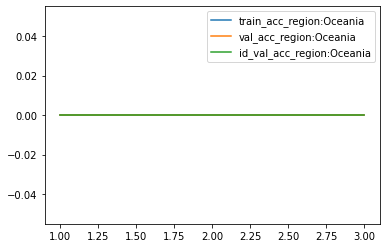

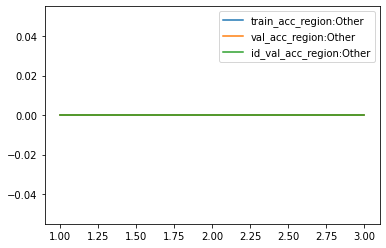

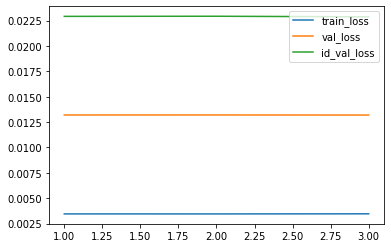

In [7]:
metrics = list(train_evolution[0].keys())

for metric in metrics:
	plot_graph(metric, train_evolution, val_evolution, id_val_evolution, NUM_EPOCHS)